<a href="https://colab.research.google.com/github/Dinesh29nov/AI/blob/master/MulitLabelSentimentClassificationUsingCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10
# why maximum vocabulary size is 20000
# becz a research said that a native english speaker knows approximately 20000
# the research is very popular

In [4]:
if not os.path.exists('glove.6B.zip'):
  ! wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-05 10:09:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-05 10:09:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-05 10:09:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
if not os.path.exists('glove.6B.50d.txt'):
  ! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
word2vec = {}
with open('glove.6B.%sd.txt'%EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.array(values[1:], dtype='float32')
    word2vec[word] = vec
    

In [7]:
for k,v in word2vec.items():
  print(k)
  print(v)
  break

the
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

In [0]:
train = pd.read_csv('/content/drive/My Drive/DataNLP/TOXIC_COMMENTS/train.csv')

In [9]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
sentences = train['comment_text'].fillna('DUMMY_VALUE').values

In [0]:
column_name = list(train.columns.values)

In [12]:
print(column_name)
column_name = column_name[2:]
print(column_name)

['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [0]:
targets = train[column_name].values

In [14]:
print("max length sentences is ", max(len(s) for s in sentences))
print("minimum length sentences is ", min(len(s) for s in sentences))

max length sentences is  5000
minimum length sentences is  6


In [15]:
s = sorted(len(s) for s in sentences)
print("median length is ", s[len(s)//2])

median length is  205


In [0]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)

In [17]:
tokenizer

In [0]:
sequences = tokenizer.texts_to_sequences(sentences)

In [19]:
print("sequences are :: ", sequences[0])

sequences are ::  [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [20]:
word2idx = tokenizer.word_index
print(len(word2idx))

210337


In [0]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [22]:
print("The shape of the data is ", data.shape)

The shape of the data is  (159571, 100)


In [0]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

## <b> Embedding Layer from Pre-trained Glove Model

In [25]:

embedding_layer = Embedding(
                      num_words, 
                      EMBEDDING_DIM,
                      weights = [embedding_matrix],
                      input_length = MAX_SEQUENCE_LENGTH,
                      trainable = False
                      )

## <b> Building Model

In [26]:
input_ = Input(shape = (MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(len(column_name), activation = 'sigmoid')(x)

In [27]:
model = Model(input_, output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 128)            4928

In [28]:
model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
outputofmodel = model.fit(data, targets, 
                         batch_size = BATCH_SIZE,
                         epochs = EPOCHS,
                         validation_split = VALIDATION_SPLIT)



Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 93s 727us/step - loss: 0.6560 - acc: 0.9532 - val_loss: 0.5799 - val_acc: 0.9635
Epoch 2/10
127656/127656 [==============================] - 92s 720us/step - loss: 0.6798 - acc: 0.9574 - val_loss: 2.9551 - val_acc: 0.8142
Epoch 3/10
127656/127656 [==============================] - 92s 719us/step - loss: 0.7361 - acc: 0.9541 - val_loss: 0.5889 - val_acc: 0.9635
Epoch 4/10
127656/127656 [==============================] - 92s 719us/step - loss: 0.5914 - acc: 0.9633 - val_loss: 0.5889 - val_acc: 0.9635
Epoch 5/10
127656/127656 [==============================] - 92s 718us/step - loss: 0.5914 - acc: 0.9633 - val_loss: 0.5889 - val_acc: 0.9635
Epoch 6/10
127656/127656 [==============================] - 92s 717us/step - loss: 0.5914 - acc: 0.9633 - val_loss: 0.5889 - val_acc: 0.9635
Epoch 7/10
127656/127656 [==============================] - 93s 725us/step - loss: 0.5914 - acc: 0.96

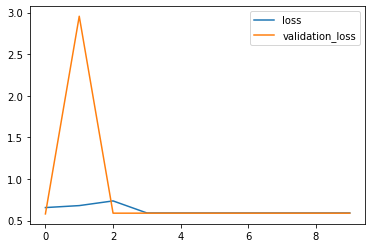

In [31]:
plt.plot(outputofmodel.history['loss'], label = 'loss')
plt.plot(outputofmodel.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

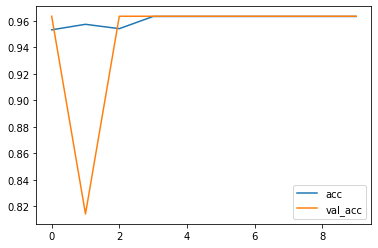

In [32]:
plt.plot(outputofmodel.history['acc'], label = 'acc')
plt.plot(outputofmodel.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

In [33]:
p = model.predict(data)
aucs = []
for j in range(6):
  auc = roc_auc_score(targets[:, j], p[:, j])
  aucs.append(auc)
  
print(np.mean(aucs))

0.5000098631001696
